In [1]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(
    fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.
- 데이터셋을 설명하는 DESCR키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담고 있는 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape); print(y.shape)

(70000, 784)
(70000,)


In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
import numpy as np
y = y.astype(np.int)
y

array([5, 0, 4, ..., 4, 5, 6])

이미지 70000개 있고 각 이미지에는 784의 특성 존재. 이미지가 28x28 픽셀이기 때문

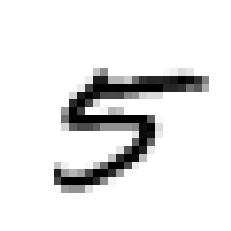

In [43]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[41000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=plt.cm.binary, interpolation = "nearest")
# cmap은 색깔 cmap=plt.cm.Reds
# interpolate(보간법) => 정확한 내용 조사 필요
plt.axis("off")
plt.show()

In [44]:
y[41000]

5

# 번외

In [42]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [43]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

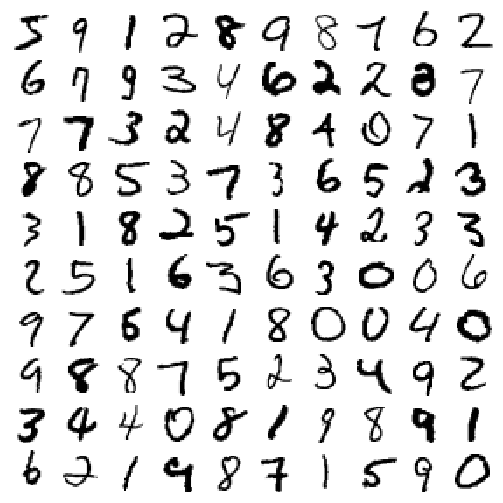

In [45]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [45]:
## 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어 놓아야 한다.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 훈련 세트를 섞어서 모든 교차 검증 폴드가 비슷해지게 만들기
### 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐

In [46]:
import numpy as np
# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 이진 분류기
- 5인가 아닌가

In [47]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## 확률적 경사 하강법 분류기로 훈련
- 매우 큰 데이터셋을 효율적으로 처리
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리
- 온라인 학습

In [48]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42) # max_iter 최대 반복 횟수
sgd_clf.fit(X_train, y_train_5)

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [49]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

## 교차 검증

In [50]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.964


C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9579
0.9571


C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [51]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring="accuracy")

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.964 , 0.9579, 0.9571])

- 모든 교차 검증 폴드에 대해 정확도가 95% 이상

In [52]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) :
    def fit(self, X, y=None) :
        pass
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype = bool)

In [53]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

- 5가 아님을 맞출 확률이 90%

## 오차 행렬
- 분류기의 성능을 평가하는 더 좋은 방법
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.
- 오차행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다.

In [55]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


- cross_val_predict는  k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.

In [57]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

- 행은 실제 클래스, 열은 예측한 클래스
- 첫 번째 행은 진짜 음성 54058개, 5아님 / 거짓 양성 521개 5라고 잘못 분류
- 두 번째 행은 거짓 음성 1899개를 5 아님으로 잘못 분류 / 진짜 양성 3522개를 정확히 5로 분류

In [58]:
y_train_perfect_predictions = y_train_5

In [59]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 정밀도와 재현율

In [60]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8711352955725946

In [63]:
3522/(3522+521)

0.8711352955725946

In [62]:
recall_score(y_train_5, y_train_pred)

0.6496956281128943

In [64]:
3522/(3522+1899)

0.6496956281128943

#### f1점수 : 정밀도와 재현율의 조화 평균

In [65]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7442941673710904

In [66]:
3522/(3522+(521+1899)/2)

0.7442941673710904

# 정밀도/재현율 트레이드오프 
- 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지

### 임계값 만들기
- 임계값이란 가설 검정에서 기각역과 채택역의 경계가 되는 값

In [67]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([159887.07307288])

In [69]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [70]:
threshold=200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### 적절한 임계값(threshold) 구하기
- cross_val_predict를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
- 하지만 예측 결과가 아니라 결정 점수를 반환 받도록 지정해야 한다.

In [71]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [73]:
y_scores.shape

(60000,)

In [74]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

C:\Anaconda3\envs\tf_test\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\envs\tf_test\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


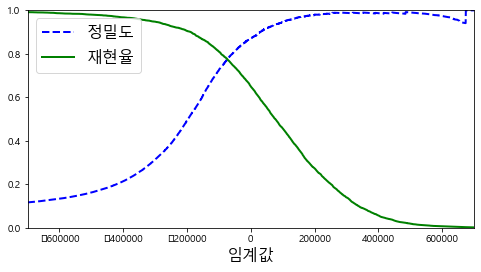

In [75]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [76]:
(y_train_pred == (y_scores > 0)).all()

True

In [77]:
y_train_pred_90 = (y_scores > 70000)

In [78]:
precision_score(y_train_5, y_train_pred_90)

0.9309882747068676

In [79]:
recall_score(y_train_5, y_train_pred_90)

0.5126360450101457

#### 재현율이 너무 낮아서 높은 정밀도의 분류기는 전혀 유용하지 않다.

## ROC 곡선(수신기 조작 특성)
- 이진 분류에서 널리 사용하는 도구
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율, 민감도)의 곡선
- FPR = 1- TNR(특이도)

In [80]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

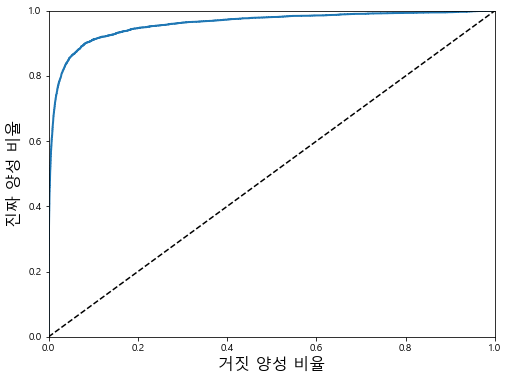

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율', fontsize=16)
    plt.ylabel('진짜 양성 비율', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

- 점선은 완전한 랜덤 분류기의 ROC 곡선
- 좋은 분류기는 이 점선으로부터 최대한 멀리 떨어져 있어야 한다(왼쪽 위 모서리)

곡선 아래의 면적 (AUC)을 측정하면 분류기들을 비교 할 수 있다.
- 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다

In [82]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9598058535696421

- 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR(정밀도/재현율)곡선을 사용
- 그렇지 않으면 ROC곡선 사용

In [83]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

※ ROC곡선을 그리려면 확률이 아니라 점수가 필요, 해결방안은 양성 클래스의 확률을 점수로 사용하는 것

In [84]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

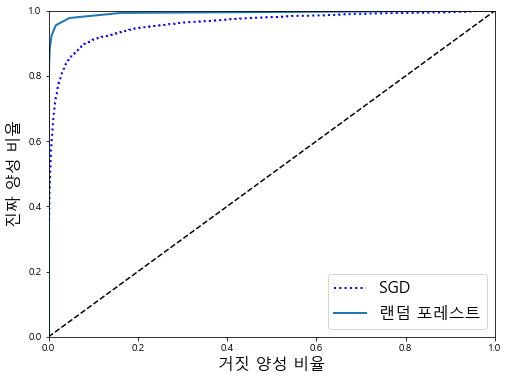

In [86]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [89]:
roc_auc_score(y_train_5, y_scores_forest)

0.9928250745111685

In [90]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9870386643233744

In [91]:
recall_score(y_train_5, y_train_pred_forest)

0.8288138719793396

# 다중 분류
- 랜덤 포레스트 분류기나 나이브 베이즈 분류기는 여러개의 클래스를 직접 처리
- SVM이나 선형 분류기는 이진 분류만 가능
- 이진 분류기를 여러개 훈련시켜 다중 클래스를 분류하는 것을 일대다(OvA)전략
- 0과 1 구별, 0과 2 구별, 1과 2구별 등 훈련시키는 것은 일대일(OvO) 전략
- SVM은 훈련 세트의 크기에 민감해서 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호

In [92]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([5])

원래 타깃 y_train을 사용해 SGDClassifier를 훈련, 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택

In [93]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-239875.201829  , -414091.55123082, -516283.6065518 ,
        -263660.37725634, -185483.58340357,  384991.35746042,
        -427438.53662219, -254387.41586426, -112275.29763296,
        -274439.19960451]])

In [94]:
np.argmax(some_digit_scores)

5

In [95]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [96]:
sgd_clf.classes_[5]

5

## SGDClassifier 기반으로 OvO전략을 사용하는 다중 분류기

In [97]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-p

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-p

array([5])

In [98]:
len(ovo_clf.estimators_)
# 0~9 10개
# 분류기 : (10*9)/2

45

## 랜덤 포레스트 분류기

In [99]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5])

In [100]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0.1, 0. , 0. ]])

In [101]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.83935, 0.85125, 0.8676 ])

In [102]:
# 입력의 스케일를 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91155, 0.91005, 0.9095 ])

# 에러 분석

In [104]:
# 오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\envs\tf_test\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5722,    2,   28,    9,    8,   49,   51,   11,   41,    2],
       [   2, 6494,   47,   23,    6,   42,    5,   10,  100,   13],
       [  51,   37, 5360,   88,   82,   23,   96,   56,  149,   16],
       [  51,   37,  149, 5318,    2,  248,   37,   57,  134,   98],
       [  19,   25,   39,    8, 5378,    7,   54,   29,   77,  206],
       [  73,   42,   35,  170,   73, 4622,  105,   30,  177,   94],
       [  31,   24,   43,    2,   43,   88, 5635,    4,   47,    1],
       [  20,   20,   65,   27,   58,   11,    6, 5806,   12,  240],
       [  53,  147,   78,  164,   11,  163,   56,   24, 5017,  138],
       [  42,   27,   25,   87,  175,   34,    3,  201,   85, 5270]],
      dtype=int64)

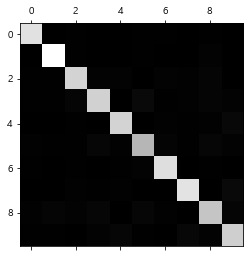

In [105]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 대부분의 이미지가 올바르게 분류되어있음을 나타내는 주대각선에 있으므로 매우 좋아 보임
- 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [107]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

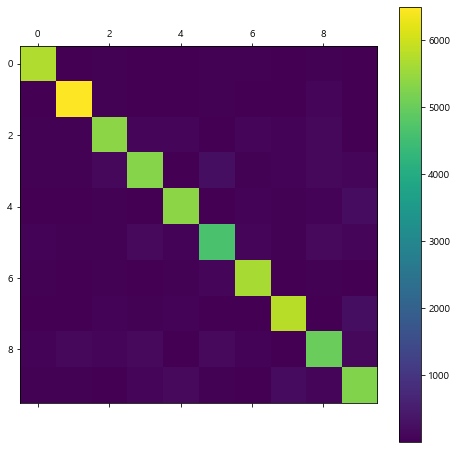

In [109]:
plot_confusion_matrix(conf_mx)
plt.show()

#### 그래프의 에러부분에 초점
- 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교 

In [110]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
row_sums

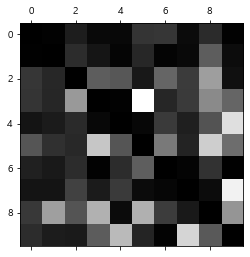

In [111]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [118]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

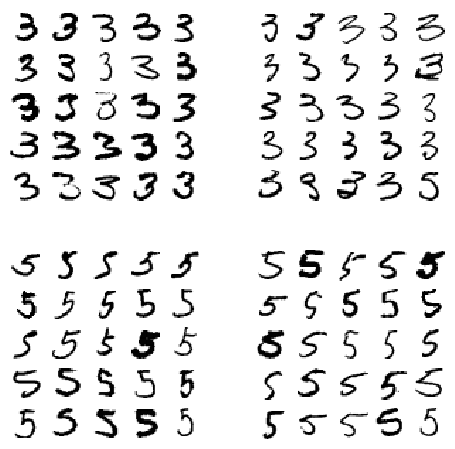

In [119]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 다중 레이블 분류

In [120]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [121]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")